<img src='https://data.cityofchicago.org/api/assets/73F1665C-0FE6-4183-8AD1-E91DB8EFAFA4?7CB02402-8E06-48B0-8C9A-3890182D58C7.png'>

## Package setup.

In [7]:
# # In case you have the wrong version of Pandas installed, remove it and install the ver that's compat with PandasAI in your venv. 
# !pip uninstall pandas -y
# !pip uninstall numpy -y

# Install some needed packages
!pip install -U pandasai --quiet
!pip install -U plotly --quiet
!pip install pyyaml --quiet

# Show the package vers
!pip show pandas
!pip show pandasai

## Read the local crime csv

In [8]:
import pandas as pd
crime = pd.read_csv('./chicago_iucr.csv')

import warnings
warnings.filterwarnings('ignore')


## Create a head Df to help the AI with col name descs. 

In [9]:
df_head = crime.head(3)
#df_head

In [10]:
field_descriptions = {
    "id": "Unique identifier for the record.",
    "date": "The Date when the incident occurred. Stored as text.",
    "block": "Partially redacted address where the incident occurred, within the same block as the actual address.",
    "location_description": "Description of the location where the incident occurred.",
    "arrest": "Indicates whether an arrest was made.",
    "domestic": "Indicates whether the incident was domestic-related as per the Illinois Domestic Violence Act.",
    "beat": "Police beat where the incident occurred, part of the smallest police geographic area.",
    "district": "Police district where the incident occurred.",
    "ward": "City Council district (ward) where the incident occurred.",
    "community_area": "Indicates the community area where the incident occurred, with Chicago having 77 community areas.",
    "fbi_code": "Crime classification as outlined in the FBI's National Incident-Based Reporting System (NIBRS).",
    "latitude": "Latitude of the incident location, shifted for partial redaction but on the same block.",
    "longitude": "Longitude of the incident location, shifted for partial redaction but on the same block.",
    "crime": "The crime committed, aka the incident."
}


## Import all our Pandas AI stuff & set up our GPT Model (Azure, OpenAI or Local) Behavior

In [11]:
import os
from pandasai import SmartDataframe
from pandasai.llm import AzureOpenAI
from pandasai.llm.local_llm import LocalLLM
from pandasai.llm import OpenAI
from pandasai import Agent
from pandasai.llm.openai import OpenAI
from pandasai.connectors import PandasConnector
from dotenv import load_dotenv
# Load environment variables from .env file
load_dotenv()

# Get my Openai Var Key
open_ai_key = os.getenv('OPENAI_API_KEY')

# Choose the model
select_model = 'OpenAI' #OpenAI $$, #AzureOpenAI #Presdio #Local MyModel mY Macbook

if select_model == 'Azure':
    # Define the LLM model for Azure (if True)
    azure_api_key = os.getenv('AZURE_OPENAI_API_KEY')
    azure_api_ver = os.getenv('AZURE_API_VERSION')
    azure_api_endpt = os.getenv('AZURE_OPENAI_ENDPOINT')
    azure_oai_deployment = os.getenv('AZURE_OPENAI_DEPLOYMENT')
    llm = AzureOpenAI(
        api_token=azure_api_key,
        azure_endpoint=azure_api_endpt,
        api_version=azure_api_ver,
        deployment_name=azure_oai_deployment,
        temperature=0,
        seed=26,
    )
elif select_model == 'OpenAI':
    openai_api_key = os.getenv('OPENAI_API_KEY')
    llm = OpenAI(api_token=openai_api_key, 
                 temperature=0,
                 seed=35,
                )
    
elif select_model == 'Local':
    llm = LocalLLM(api_base="http://host.docker.internal:1234/v1",
                  temperature=0, 
                  seed=55,
                  )


# A description of the overall table
description = '''You are a data analysis agent. Your main goal is to help non-technical users to analyze data.\
                This dataset reflects reported incidents of crime (with the exception of murders where \
                data exists for each victim) that occurred in the City of Chicago from 2001 to present, \
                minus the most recent seven days. Data is extracted from the Chicago Police Department's \
                CLEAR (Citizen Law Enforcement Analysis and Reporting) system. In order to protect the privacy of crime victims, \
                addresses are shown at the block level only and specific locations are not identified. '''

# Define my connector
agent = Agent(crime, config={'llm': llm,
                            'description': description,
                            'enable_cache': False,
                            'verbose': False,
                            'field_description': field_descriptions,
                            'save_charts': False,
                            'save_charts_path': './saved_plots',
                            'open_charts': False,
                            }
             )

## Simple Chat

'/Users/eric/Library/CloudStorage/OneDrive-Personal/dev/pandasAi/exports/charts/temp_chart.png'

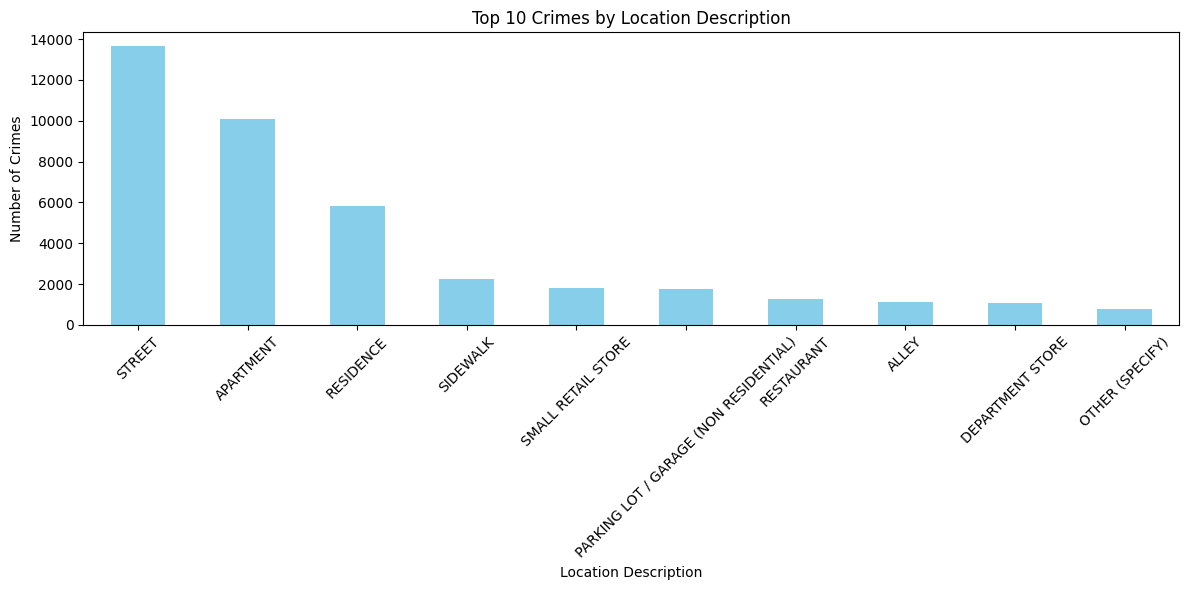

In [12]:
query = ''' Graph the top 10 crime by location_description and if the location_description is missing in any way, then make it say unknown.  '''
agent.chat(query=query)

In [13]:
print(agent.last_code_generated)

# TODO: import the required dependencies
import pandas as pd
import matplotlib.pyplot as plt

# Combine all dataframes in dfs list
df = pd.concat(dfs)

# Replace missing location_description with "Unknown"
df['location_description'] = df['location_description'].fillna('Unknown')

# Group by location_description and count the number of crimes
top_crimes = df['crime'].groupby(df['location_description']).count().nlargest(10)

# Plot the top 10 crimes by location_description
plt.figure(figsize=(12, 6))
top_crimes.plot(kind='bar', color='skyblue')
plt.title('Top 10 Crimes by Location Description')
plt.xlabel('Location Description')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot as a png file
plt.savefig('top_crimes_by_location.png')

# Declare result variable as a dictionary
result = {"type": "plot", "value": "top_crimes_by_location.png"}


In [14]:
agent.explain()

'I looked at the data we have and noticed that some location descriptions were missing. To make sure we include all locations, I filled in those missing values with "Unknown". Then, I grouped the crimes by location description and counted how many crimes occurred in each location. After that, I selected the top 10 locations with the most crimes. Finally, I created a bar chart to visualize this information, with the x-axis showing the location descriptions and the y-axis showing the number of crimes. I saved the chart as an image file for you to view later.'